In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2, torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.utils import resample
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
import matplotlib.cm as colormap
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import torchvision.models as models
import time

In [2]:
train_dir = '/kaggle/input/fer2013/FER2013/train/'
val_dir = '/kaggle/input/fer2013/FER2013/validation/'
test_dir ='/kaggle/input/fer2013/FER2013/test/'

train_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(train_dir) for f in filenames if f.endswith(('.jpg', '.png'))]
val_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(val_dir) for f in filenames if f.endswith(('.jpg', '.png'))]
test_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(test_dir) for f in filenames if f.endswith(('.jpg', '.png'))]

print('train_images:',len(train_images))
print('val_images:',len(val_images))
print('test_images:',len(test_images))


train_images: 3208
val_images: 809
test_images: 1020


In [3]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.Resize((224, 224))
    ])

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224, 224))
    ])

class dataset(Dataset):
    def __init__(self, images_dir, transform, device):
        self.images_dir = images_dir
        self.transform = transform
        self.device = device
        self.class_names = sorted(os.listdir(self.images_dir))
        self.image_paths = []
        self.labels = []
        for i, class_name in enumerate(self.class_names):
            class_path = os.path.join(self.images_dir, class_name)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.image_paths.append(image_path)
                self.labels.append(i)
        self.device = device
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = cv2.imread(image_path)
        image = self.transform(image).to(self.device)
        label = torch.LongTensor([label]).to(self.device)
        return image, label

In [4]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
torch.cuda.empty_cache()

train_data = dataset(train_dir, train_transforms, device)
train_loader = DataLoader(train_data, batch_size = 128, shuffle = True)

val_data = dataset(val_dir, train_transforms, device)
val_loader = DataLoader(val_data, batch_size = 128, shuffle = True)

test_data = dataset(test_dir, test_transforms, device)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = False)

In [5]:
def plot_data_loader(data_loader, gridDims, class_names):
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, labels = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
            axes[i, j].set_title(class_names[labels[0]])
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

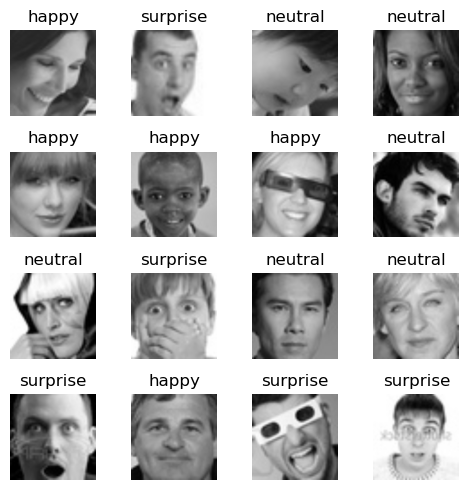

In [6]:
plot_data_loader(train_loader, (4, 4), train_data.class_names)

In [7]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_loader):
        labels = labels.reshape(-1)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

In [8]:
def val_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            labels = labels.reshape(-1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    return epoch_loss, epoch_acc

In [9]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    all_probs = []
    all_labelsForProbs = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            labels = labels.reshape(-1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labelsForProbs.append(labels.cpu().numpy())
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds += preds.cpu().numpy().tolist()
            all_labels += labels.cpu().numpy().tolist()
    all_probs = np.concatenate(all_probs)
    all_labelsForProbs = np.concatenate(all_labelsForProbs)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    epoch_classification_report = classification_report(all_labels, all_preds)
    print(f'Test Results:')
    print(f'Test Accuracy: {epoch_acc:.4f}')
    print(f'\n{epoch_classification_report}')
    cm = confusion_matrix(all_labels, all_preds)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                     xticklabels=train_data.class_names, yticklabels=test_data.class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    n_classes = len(test_data.class_names)
    y_test = label_binarize(all_labelsForProbs, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], all_probs[:, i])
        roc_auc[i] = roc_auc_score(y_test[:, i], all_probs[:, i], average='macro')
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), all_probs.ravel())
    roc_auc["micro"] = roc_auc_score(y_test, all_probs, average="micro")
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=4)
    label_names = test_data.class_names
    cmap = colormap.get_cmap('tab20',len(label_names))
    colors = [cmap(i) for i in range(len(label_names))]
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label=f'{test_data.class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

FLOPS: 990.436 billion


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Epoch 1/25 | Train Loss: 4.2615 | Train Acc: 0.3466 | Val Loss: 14858.3195 | Val Acc: 0.3449


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 2/25 | Train Loss: 1.3290 | Train Acc: 0.4118 | Val Loss: 1.3924 | Val Acc: 0.4129


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 3/25 | Train Loss: 1.1443 | Train Acc: 0.4224 | Val Loss: 0.8631 | Val Acc: 0.3931


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 4/25 | Train Loss: 1.0802 | Train Acc: 0.4099 | Val Loss: 0.8689 | Val Acc: 0.4054


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch 5/25 | Train Loss: 1.0678 | Train Acc: 0.4146 | Val Loss: 0.8652 | Val Acc: 0.4091


100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 6/25 | Train Loss: 1.0538 | Train Acc: 0.4352 | Val Loss: 0.9581 | Val Acc: 0.3807


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 7/25 | Train Loss: 1.0421 | Train Acc: 0.4517 | Val Loss: 0.9170 | Val Acc: 0.3857


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 8/25 | Train Loss: 1.0582 | Train Acc: 0.4336 | Val Loss: 1.0983 | Val Acc: 0.3770


100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


Epoch 9/25 | Train Loss: 1.0274 | Train Acc: 0.4685 | Val Loss: 1.2117 | Val Acc: 0.3313
Early stopping at epoch 9 with best validation accuracy of 0.4129
Results for lr=0.1
Train Loss: 1.0274 | Train Acc: 0.4685 | Val Loss: 1.2117 | Val Acc: 0.3313

Average time per epoch: 18.69 seconds
FLOPS: 990.436 billion


100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


Epoch 1/25 | Train Loss: 1.6851 | Train Acc: 0.3653 | Val Loss: 168.8145 | Val Acc: 0.3066


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Epoch 2/25 | Train Loss: 1.1666 | Train Acc: 0.3494 | Val Loss: 2.7743 | Val Acc: 0.3844


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 3/25 | Train Loss: 1.1729 | Train Acc: 0.3893 | Val Loss: 35.3500 | Val Acc: 0.3597


100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 4/25 | Train Loss: 1.2164 | Train Acc: 0.3834 | Val Loss: 1.3864 | Val Acc: 0.3869


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 5/25 | Train Loss: 1.1233 | Train Acc: 0.4177 | Val Loss: 0.8817 | Val Acc: 0.3894


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch 6/25 | Train Loss: 1.1469 | Train Acc: 0.3946 | Val Loss: 0.8501 | Val Acc: 0.4314


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 7/25 | Train Loss: 1.0776 | Train Acc: 0.4395 | Val Loss: 0.8523 | Val Acc: 0.4153


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 8/25 | Train Loss: 1.0871 | Train Acc: 0.4342 | Val Loss: 1.0081 | Val Acc: 0.3918


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 9/25 | Train Loss: 1.0663 | Train Acc: 0.4330 | Val Loss: 0.8456 | Val Acc: 0.4240


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch 10/25 | Train Loss: 1.0613 | Train Acc: 0.4567 | Val Loss: 0.8714 | Val Acc: 0.4067


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch 11/25 | Train Loss: 1.0430 | Train Acc: 0.4483 | Val Loss: 0.9014 | Val Acc: 0.3918


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 12/25 | Train Loss: 1.0167 | Train Acc: 0.4847 | Val Loss: 0.9070 | Val Acc: 0.3758


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch 13/25 | Train Loss: 1.0217 | Train Acc: 0.4663 | Val Loss: 0.9167 | Val Acc: 0.3708
Early stopping at epoch 13 with best validation accuracy of 0.4314
Results for lr=0.01
Train Loss: 1.0217 | Train Acc: 0.4663 | Val Loss: 0.9167 | Val Acc: 0.3708

Average time per epoch: 16.29 seconds
FLOPS: 990.436 billion


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 1/25 | Train Loss: 0.6277 | Train Acc: 0.7444 | Val Loss: 0.5478 | Val Acc: 0.7602


100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


Epoch 2/25 | Train Loss: 0.3974 | Train Acc: 0.8479 | Val Loss: 0.3657 | Val Acc: 0.8257


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch 3/25 | Train Loss: 0.3229 | Train Acc: 0.8772 | Val Loss: 0.3472 | Val Acc: 0.8393


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch 4/25 | Train Loss: 0.2702 | Train Acc: 0.8937 | Val Loss: 0.4108 | Val Acc: 0.8257


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 5/25 | Train Loss: 0.2556 | Train Acc: 0.9099 | Val Loss: 0.4765 | Val Acc: 0.7676


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch 6/25 | Train Loss: 0.3850 | Train Acc: 0.8554 | Val Loss: 0.3473 | Val Acc: 0.8504


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 7/25 | Train Loss: 0.2514 | Train Acc: 0.9118 | Val Loss: 0.3147 | Val Acc: 0.8591


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 8/25 | Train Loss: 0.1665 | Train Acc: 0.9417 | Val Loss: 0.4002 | Val Acc: 0.8653


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 9/25 | Train Loss: 0.2142 | Train Acc: 0.9246 | Val Loss: 0.3682 | Val Acc: 0.8492


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 10/25 | Train Loss: 0.1828 | Train Acc: 0.9330 | Val Loss: 0.4134 | Val Acc: 0.8307


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 11/25 | Train Loss: 0.2604 | Train Acc: 0.9024 | Val Loss: 0.5364 | Val Acc: 0.7713


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 12/25 | Train Loss: 0.1923 | Train Acc: 0.9258 | Val Loss: 0.4060 | Val Acc: 0.8504


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 13/25 | Train Loss: 0.2492 | Train Acc: 0.9090 | Val Loss: 0.3965 | Val Acc: 0.8443


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 14/25 | Train Loss: 0.1610 | Train Acc: 0.9401 | Val Loss: 0.3571 | Val Acc: 0.8541


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 15/25 | Train Loss: 0.0984 | Train Acc: 0.9663 | Val Loss: 0.4349 | Val Acc: 0.8529
Early stopping at epoch 15 with best validation accuracy of 0.8653
Results for lr=0.001
Train Loss: 0.0984 | Train Acc: 0.9663 | Val Loss: 0.4349 | Val Acc: 0.8529

Average time per epoch: 15.91 seconds
FLOPS: 990.436 billion


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 1/25 | Train Loss: 0.7049 | Train Acc: 0.6783 | Val Loss: 0.5252 | Val Acc: 0.6996


100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


Epoch 2/25 | Train Loss: 0.3431 | Train Acc: 0.8731 | Val Loss: 0.3789 | Val Acc: 0.8133


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 3/25 | Train Loss: 0.1996 | Train Acc: 0.9349 | Val Loss: 0.3447 | Val Acc: 0.8331


100%|██████████| 7/7 [00:02<00:00,  2.74it/s]


Epoch 4/25 | Train Loss: 0.1380 | Train Acc: 0.9592 | Val Loss: 0.3224 | Val Acc: 0.8578


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 5/25 | Train Loss: 0.0847 | Train Acc: 0.9832 | Val Loss: 0.3481 | Val Acc: 0.8517


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 6/25 | Train Loss: 0.0554 | Train Acc: 0.9857 | Val Loss: 0.3525 | Val Acc: 0.8640


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 7/25 | Train Loss: 0.0544 | Train Acc: 0.9850 | Val Loss: 0.3779 | Val Acc: 0.8529


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch 8/25 | Train Loss: 0.0439 | Train Acc: 0.9897 | Val Loss: 0.3951 | Val Acc: 0.8640


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 9/25 | Train Loss: 0.0236 | Train Acc: 0.9956 | Val Loss: 0.3758 | Val Acc: 0.8628


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 10/25 | Train Loss: 0.0146 | Train Acc: 0.9978 | Val Loss: 0.3981 | Val Acc: 0.8566


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 11/25 | Train Loss: 0.0518 | Train Acc: 0.9850 | Val Loss: 0.4443 | Val Acc: 0.8344


100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch 12/25 | Train Loss: 0.0204 | Train Acc: 0.9975 | Val Loss: 0.3941 | Val Acc: 0.8554


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch 13/25 | Train Loss: 0.0097 | Train Acc: 0.9988 | Val Loss: 0.3802 | Val Acc: 0.8690


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 14/25 | Train Loss: 0.0078 | Train Acc: 0.9997 | Val Loss: 0.4056 | Val Acc: 0.8640


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 15/25 | Train Loss: 0.0040 | Train Acc: 0.9997 | Val Loss: 0.4487 | Val Acc: 0.8529


100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 16/25 | Train Loss: 0.0778 | Train Acc: 0.9757 | Val Loss: 0.5034 | Val Acc: 0.8183


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 17/25 | Train Loss: 0.0519 | Train Acc: 0.9863 | Val Loss: 0.5357 | Val Acc: 0.8492


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 18/25 | Train Loss: 0.0180 | Train Acc: 0.9969 | Val Loss: 0.4471 | Val Acc: 0.8492


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Epoch 19/25 | Train Loss: 0.0260 | Train Acc: 0.9916 | Val Loss: 0.4586 | Val Acc: 0.8541


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 20/25 | Train Loss: 0.0142 | Train Acc: 0.9975 | Val Loss: 0.4237 | Val Acc: 0.8665
Early stopping at epoch 20 with best validation accuracy of 0.8690
Results for lr=0.0001
Train Loss: 0.0142 | Train Acc: 0.9975 | Val Loss: 0.4237 | Val Acc: 0.8665

Average time per epoch: 15.51 seconds
FLOPS: 990.436 billion


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 1/25 | Train Loss: 1.0418 | Train Acc: 0.4679 | Val Loss: 0.8190 | Val Acc: 0.4994


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 2/25 | Train Loss: 0.8301 | Train Acc: 0.6587 | Val Loss: 0.6992 | Val Acc: 0.5983


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 3/25 | Train Loss: 0.6972 | Train Acc: 0.7335 | Val Loss: 0.5891 | Val Acc: 0.6897


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch 4/25 | Train Loss: 0.6003 | Train Acc: 0.7771 | Val Loss: 0.5009 | Val Acc: 0.7528


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch 5/25 | Train Loss: 0.5271 | Train Acc: 0.7980 | Val Loss: 0.4571 | Val Acc: 0.7676


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch 6/25 | Train Loss: 0.4652 | Train Acc: 0.8438 | Val Loss: 0.4242 | Val Acc: 0.7985


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 7/25 | Train Loss: 0.4204 | Train Acc: 0.8622 | Val Loss: 0.4127 | Val Acc: 0.8059


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch 8/25 | Train Loss: 0.3797 | Train Acc: 0.8731 | Val Loss: 0.3848 | Val Acc: 0.8146


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 9/25 | Train Loss: 0.3494 | Train Acc: 0.8837 | Val Loss: 0.3853 | Val Acc: 0.8109


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 10/25 | Train Loss: 0.3124 | Train Acc: 0.9012 | Val Loss: 0.3606 | Val Acc: 0.8245


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch 11/25 | Train Loss: 0.2877 | Train Acc: 0.9102 | Val Loss: 0.3615 | Val Acc: 0.8331


100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 12/25 | Train Loss: 0.2702 | Train Acc: 0.9174 | Val Loss: 0.3605 | Val Acc: 0.8208


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 13/25 | Train Loss: 0.2443 | Train Acc: 0.9339 | Val Loss: 0.3461 | Val Acc: 0.8368


100%|██████████| 7/7 [00:02<00:00,  2.75it/s]


Epoch 14/25 | Train Loss: 0.2195 | Train Acc: 0.9423 | Val Loss: 0.3559 | Val Acc: 0.8307


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 15/25 | Train Loss: 0.2035 | Train Acc: 0.9495 | Val Loss: 0.3477 | Val Acc: 0.8430


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 16/25 | Train Loss: 0.1888 | Train Acc: 0.9554 | Val Loss: 0.3474 | Val Acc: 0.8331


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch 17/25 | Train Loss: 0.1739 | Train Acc: 0.9585 | Val Loss: 0.3546 | Val Acc: 0.8368


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch 18/25 | Train Loss: 0.1655 | Train Acc: 0.9589 | Val Loss: 0.3471 | Val Acc: 0.8307


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 19/25 | Train Loss: 0.1471 | Train Acc: 0.9698 | Val Loss: 0.3510 | Val Acc: 0.8381


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 20/25 | Train Loss: 0.1291 | Train Acc: 0.9760 | Val Loss: 0.3407 | Val Acc: 0.8443


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 21/25 | Train Loss: 0.1196 | Train Acc: 0.9766 | Val Loss: 0.3551 | Val Acc: 0.8405


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch 22/25 | Train Loss: 0.1111 | Train Acc: 0.9819 | Val Loss: 0.3456 | Val Acc: 0.8480


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch 23/25 | Train Loss: 0.0969 | Train Acc: 0.9866 | Val Loss: 0.3407 | Val Acc: 0.8467


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 24/25 | Train Loss: 0.0949 | Train Acc: 0.9853 | Val Loss: 0.3367 | Val Acc: 0.8517


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch 25/25 | Train Loss: 0.0819 | Train Acc: 0.9869 | Val Loss: 0.3459 | Val Acc: 0.8405
Results for lr=1e-05
Train Loss: 0.0819 | Train Acc: 0.9869 | Val Loss: 0.3459 | Val Acc: 0.8405

Average time per epoch: 15.69 seconds
FLOPS: 990.436 billion


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch 1/25 | Train Loss: 1.1350 | Train Acc: 0.3840 | Val Loss: 0.9650 | Val Acc: 0.3449


100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


Epoch 2/25 | Train Loss: 1.1091 | Train Acc: 0.3971 | Val Loss: 0.8973 | Val Acc: 0.3906


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 3/25 | Train Loss: 1.0839 | Train Acc: 0.4286 | Val Loss: 0.8539 | Val Acc: 0.4413


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 4/25 | Train Loss: 1.0606 | Train Acc: 0.4417 | Val Loss: 0.8256 | Val Acc: 0.4685


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 5/25 | Train Loss: 1.0351 | Train Acc: 0.4698 | Val Loss: 0.8099 | Val Acc: 0.4747


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch 6/25 | Train Loss: 1.0144 | Train Acc: 0.4863 | Val Loss: 0.7966 | Val Acc: 0.5105


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 7/25 | Train Loss: 0.9893 | Train Acc: 0.5193 | Val Loss: 0.7911 | Val Acc: 0.5080


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 8/25 | Train Loss: 0.9750 | Train Acc: 0.5218 | Val Loss: 0.7703 | Val Acc: 0.5525


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 9/25 | Train Loss: 0.9565 | Train Acc: 0.5480 | Val Loss: 0.7623 | Val Acc: 0.5476


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 10/25 | Train Loss: 0.9388 | Train Acc: 0.5639 | Val Loss: 0.7448 | Val Acc: 0.5637


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 11/25 | Train Loss: 0.9130 | Train Acc: 0.5795 | Val Loss: 0.7393 | Val Acc: 0.5760


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch 12/25 | Train Loss: 0.8920 | Train Acc: 0.6100 | Val Loss: 0.7164 | Val Acc: 0.5884


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 13/25 | Train Loss: 0.8759 | Train Acc: 0.6191 | Val Loss: 0.7085 | Val Acc: 0.6032


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 14/25 | Train Loss: 0.8574 | Train Acc: 0.6409 | Val Loss: 0.6876 | Val Acc: 0.6366


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 15/25 | Train Loss: 0.8401 | Train Acc: 0.6450 | Val Loss: 0.6831 | Val Acc: 0.6354


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch 16/25 | Train Loss: 0.8238 | Train Acc: 0.6730 | Val Loss: 0.6679 | Val Acc: 0.6489


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 17/25 | Train Loss: 0.8101 | Train Acc: 0.6746 | Val Loss: 0.6549 | Val Acc: 0.6625


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 18/25 | Train Loss: 0.7987 | Train Acc: 0.6914 | Val Loss: 0.6487 | Val Acc: 0.6638


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Epoch 19/25 | Train Loss: 0.7801 | Train Acc: 0.7039 | Val Loss: 0.6350 | Val Acc: 0.6650


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch 20/25 | Train Loss: 0.7685 | Train Acc: 0.7166 | Val Loss: 0.6234 | Val Acc: 0.6836


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch 21/25 | Train Loss: 0.7474 | Train Acc: 0.7248 | Val Loss: 0.6101 | Val Acc: 0.6959


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch 22/25 | Train Loss: 0.7363 | Train Acc: 0.7276 | Val Loss: 0.6032 | Val Acc: 0.6786


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 23/25 | Train Loss: 0.7228 | Train Acc: 0.7350 | Val Loss: 0.5963 | Val Acc: 0.6897


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 24/25 | Train Loss: 0.7105 | Train Acc: 0.7481 | Val Loss: 0.5896 | Val Acc: 0.7157


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 25/25 | Train Loss: 0.6959 | Train Acc: 0.7550 | Val Loss: 0.5797 | Val Acc: 0.7046
Results for lr=1e-06
Train Loss: 0.6959 | Train Acc: 0.7550 | Val Loss: 0.5797 | Val Acc: 0.7046

Average time per epoch: 15.50 seconds
FLOPS: 990.436 billion


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch 1/25 | Train Loss: 1.2011 | Train Acc: 0.3382 | Val Loss: 0.9478 | Val Acc: 0.3276


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 2/25 | Train Loss: 1.1954 | Train Acc: 0.3469 | Val Loss: 0.9721 | Val Acc: 0.3115


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch 3/25 | Train Loss: 1.1943 | Train Acc: 0.3401 | Val Loss: 0.9331 | Val Acc: 0.3288


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 4/25 | Train Loss: 1.1935 | Train Acc: 0.3395 | Val Loss: 0.9316 | Val Acc: 0.3214


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 5/25 | Train Loss: 1.1845 | Train Acc: 0.3522 | Val Loss: 0.9390 | Val Acc: 0.3276


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 6/25 | Train Loss: 1.1843 | Train Acc: 0.3582 | Val Loss: 0.9322 | Val Acc: 0.3325


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch 7/25 | Train Loss: 1.1785 | Train Acc: 0.3572 | Val Loss: 0.9362 | Val Acc: 0.3201


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 8/25 | Train Loss: 1.1757 | Train Acc: 0.3538 | Val Loss: 0.9279 | Val Acc: 0.3239


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch 9/25 | Train Loss: 1.1735 | Train Acc: 0.3526 | Val Loss: 0.9348 | Val Acc: 0.3313


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch 10/25 | Train Loss: 1.1728 | Train Acc: 0.3579 | Val Loss: 0.9219 | Val Acc: 0.3436


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 11/25 | Train Loss: 1.1675 | Train Acc: 0.3550 | Val Loss: 0.9176 | Val Acc: 0.3337


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 12/25 | Train Loss: 1.1633 | Train Acc: 0.3585 | Val Loss: 0.9225 | Val Acc: 0.3498


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch 13/25 | Train Loss: 1.1618 | Train Acc: 0.3610 | Val Loss: 0.9230 | Val Acc: 0.3300


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 14/25 | Train Loss: 1.1597 | Train Acc: 0.3557 | Val Loss: 0.9197 | Val Acc: 0.3387


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 15/25 | Train Loss: 1.1595 | Train Acc: 0.3628 | Val Loss: 0.9235 | Val Acc: 0.3251


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 16/25 | Train Loss: 1.1586 | Train Acc: 0.3557 | Val Loss: 0.9214 | Val Acc: 0.3350


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 17/25 | Train Loss: 1.1545 | Train Acc: 0.3597 | Val Loss: 0.9131 | Val Acc: 0.3399


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 18/25 | Train Loss: 1.1517 | Train Acc: 0.3572 | Val Loss: 0.9120 | Val Acc: 0.3486


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 19/25 | Train Loss: 1.1451 | Train Acc: 0.3644 | Val Loss: 0.9064 | Val Acc: 0.3498
Early stopping at epoch 19 with best validation accuracy of 0.3498
Results for lr=1e-07
Train Loss: 1.1451 | Train Acc: 0.3644 | Val Loss: 0.9064 | Val Acc: 0.3498

Average time per epoch: 15.57 seconds
FLOPS: 990.436 billion


100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 1/25 | Train Loss: 1.2246 | Train Acc: 0.3423 | Val Loss: 1.0020 | Val Acc: 0.3263


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch 2/25 | Train Loss: 1.2271 | Train Acc: 0.3382 | Val Loss: 1.0200 | Val Acc: 0.3325


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 3/25 | Train Loss: 1.2283 | Train Acc: 0.3398 | Val Loss: 1.0357 | Val Acc: 0.3387


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch 4/25 | Train Loss: 1.2245 | Train Acc: 0.3401 | Val Loss: 0.9906 | Val Acc: 0.3375


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch 5/25 | Train Loss: 1.2292 | Train Acc: 0.3398 | Val Loss: 0.9661 | Val Acc: 0.3387


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Epoch 6/25 | Train Loss: 1.2281 | Train Acc: 0.3348 | Val Loss: 0.9720 | Val Acc: 0.3300


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 7/25 | Train Loss: 1.2269 | Train Acc: 0.3373 | Val Loss: 0.9781 | Val Acc: 0.3263


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch 8/25 | Train Loss: 1.2265 | Train Acc: 0.3392 | Val Loss: 0.9707 | Val Acc: 0.3362


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch 9/25 | Train Loss: 1.2282 | Train Acc: 0.3376 | Val Loss: 0.9718 | Val Acc: 0.3375


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 10/25 | Train Loss: 1.2226 | Train Acc: 0.3392 | Val Loss: 0.9719 | Val Acc: 0.3350
Early stopping at epoch 10 with best validation accuracy of 0.3387
Results for lr=1e-08
Train Loss: 1.2226 | Train Acc: 0.3392 | Val Loss: 0.9719 | Val Acc: 0.3350

Average time per epoch: 16.33 seconds
FLOPS: 990.436 billion


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 1/25 | Train Loss: 1.1482 | Train Acc: 0.3370 | Val Loss: 0.9436 | Val Acc: 0.3152


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 2/25 | Train Loss: 1.1434 | Train Acc: 0.3513 | Val Loss: 0.9433 | Val Acc: 0.3152


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 3/25 | Train Loss: 1.1428 | Train Acc: 0.3398 | Val Loss: 0.9248 | Val Acc: 0.3560


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch 4/25 | Train Loss: 1.1441 | Train Acc: 0.3438 | Val Loss: 0.8951 | Val Acc: 0.3684


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 5/25 | Train Loss: 1.1448 | Train Acc: 0.3426 | Val Loss: 0.8988 | Val Acc: 0.3523


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch 6/25 | Train Loss: 1.1485 | Train Acc: 0.3413 | Val Loss: 0.8970 | Val Acc: 0.3511


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 7/25 | Train Loss: 1.1461 | Train Acc: 0.3392 | Val Loss: 0.8966 | Val Acc: 0.3486


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 8/25 | Train Loss: 1.1446 | Train Acc: 0.3310 | Val Loss: 0.8871 | Val Acc: 0.3622


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch 9/25 | Train Loss: 1.1474 | Train Acc: 0.3339 | Val Loss: 0.8973 | Val Acc: 0.3523


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 10/25 | Train Loss: 1.1507 | Train Acc: 0.3307 | Val Loss: 0.8970 | Val Acc: 0.3535


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 11/25 | Train Loss: 1.1479 | Train Acc: 0.3379 | Val Loss: 0.8946 | Val Acc: 0.3572
Early stopping at epoch 11 with best validation accuracy of 0.3684
Results for lr=1e-09
Train Loss: 1.1479 | Train Acc: 0.3379 | Val Loss: 0.8946 | Val Acc: 0.3572

Average time per epoch: 16.31 seconds


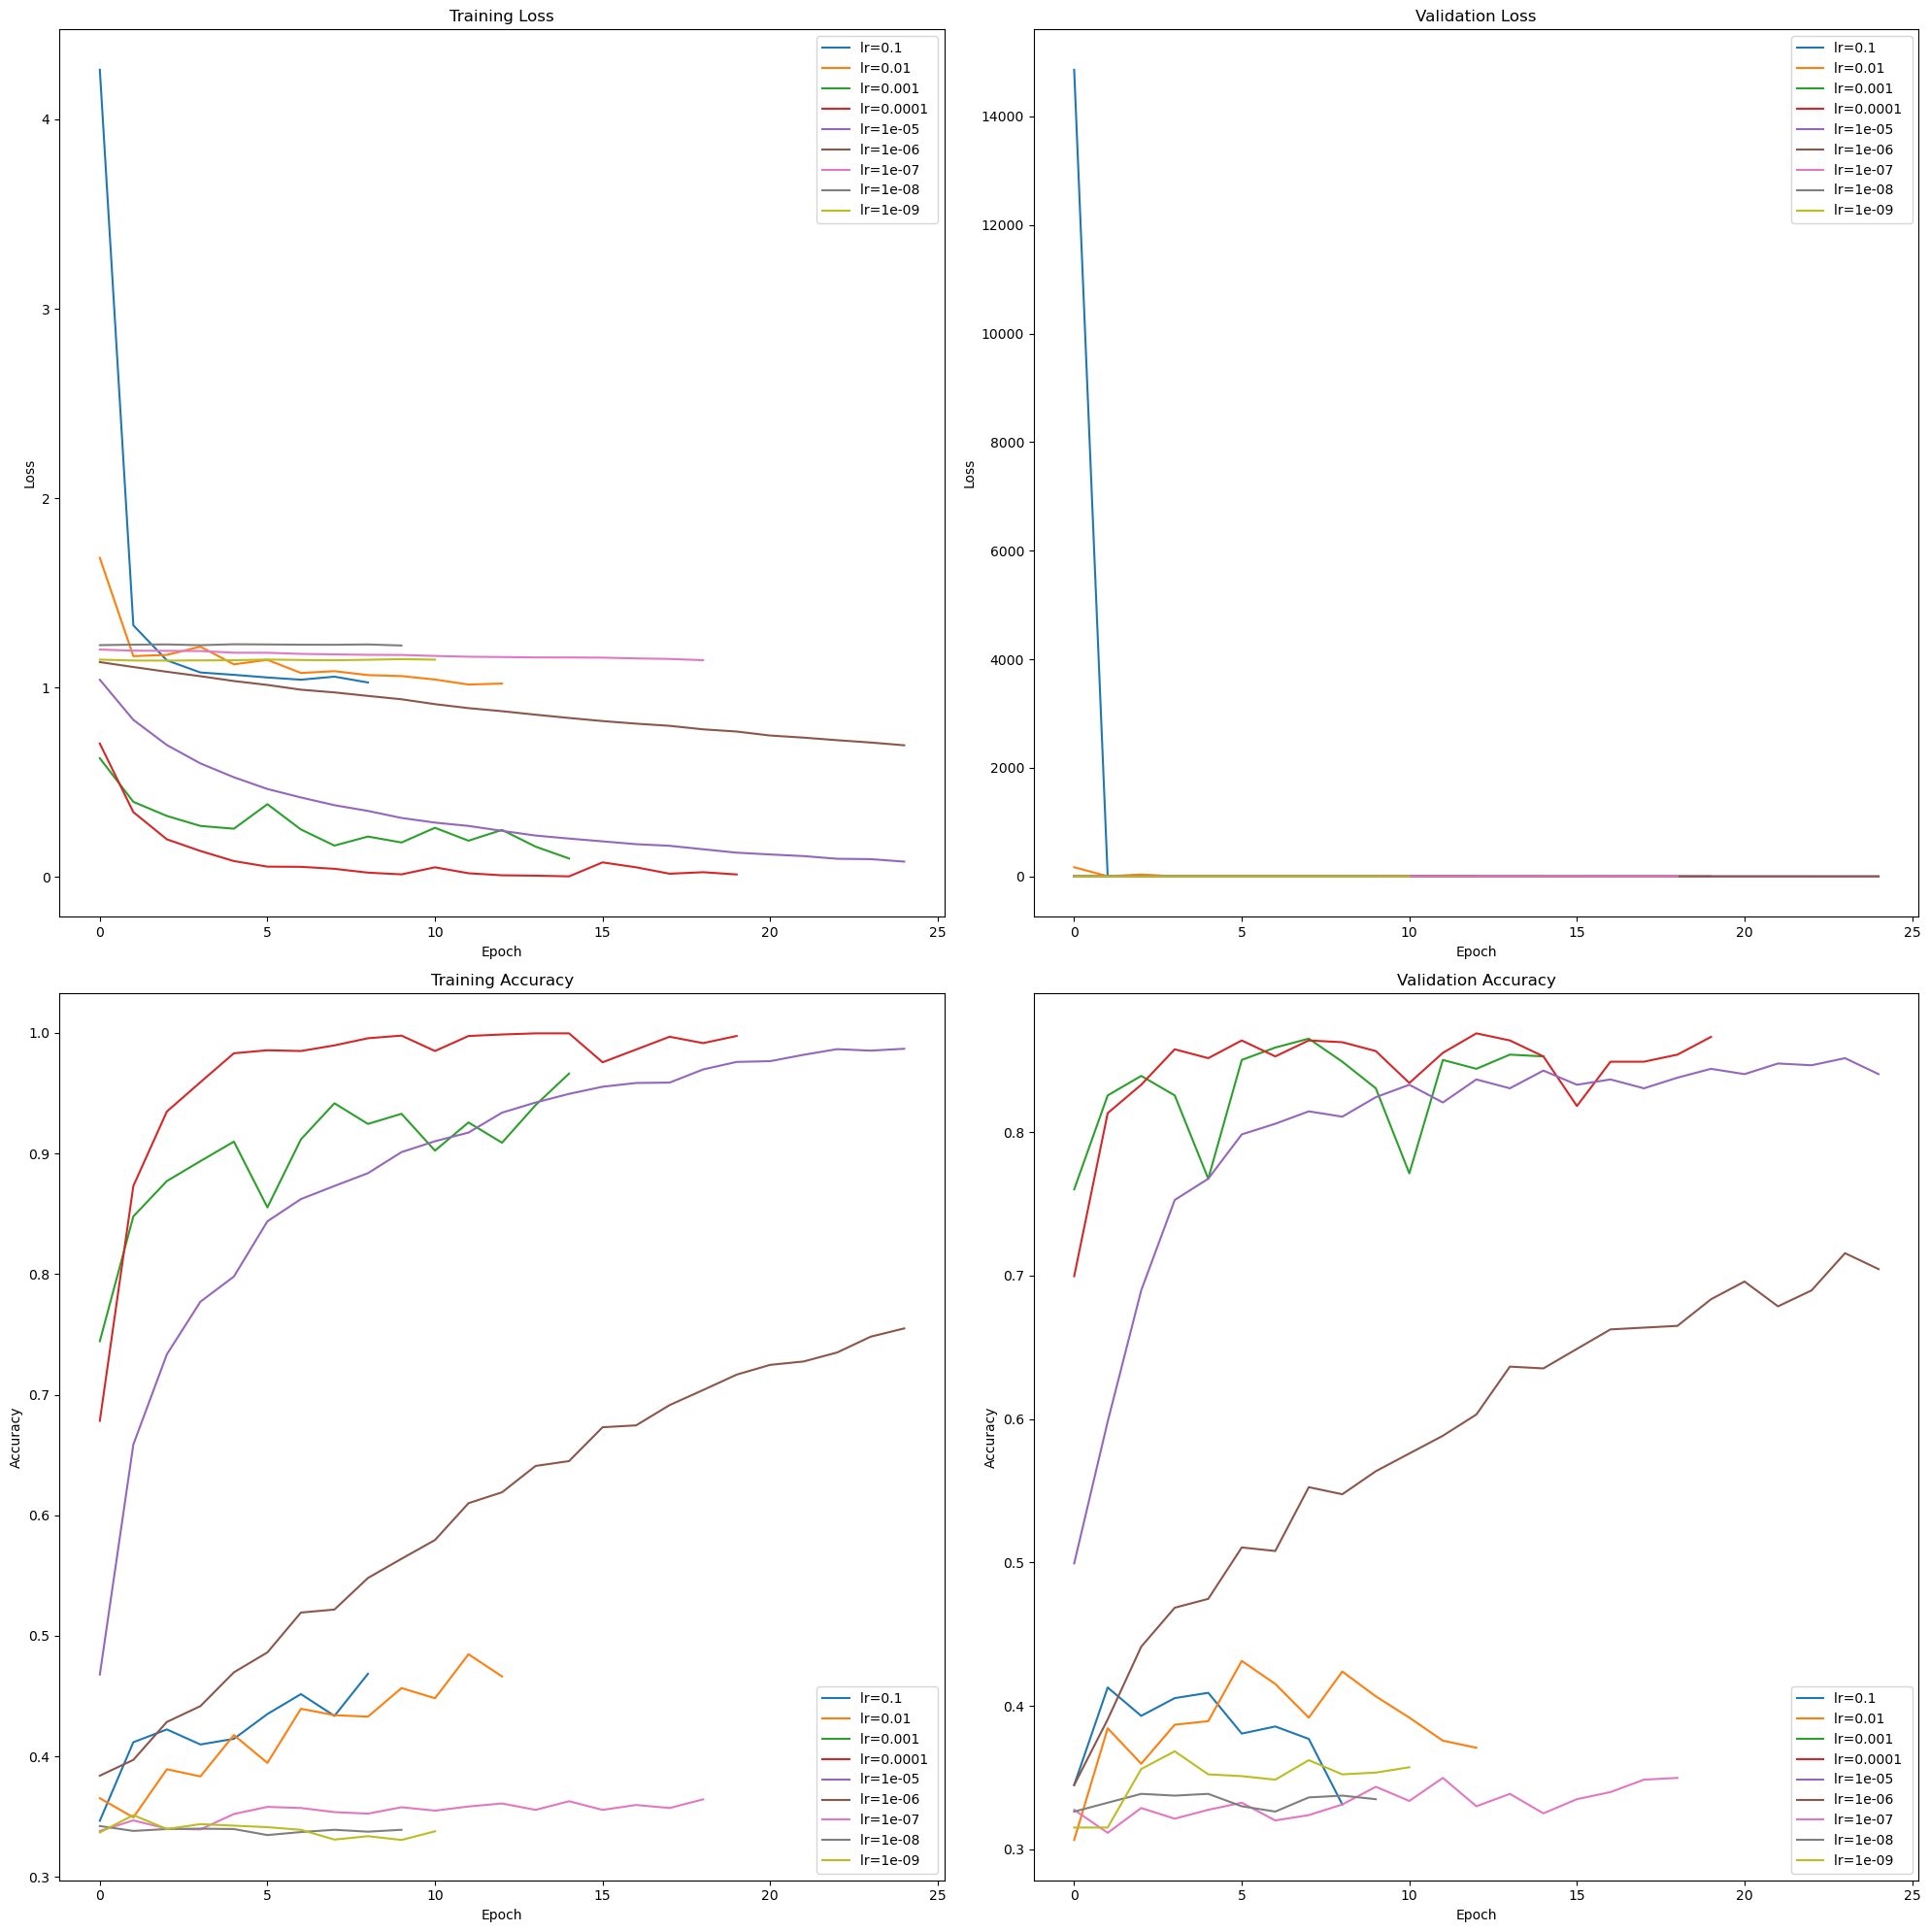

Best hyperparameters: {'lr': 0.0001}
Corresponding results: {'train_loss': 0.014157706184168705, 'train_acc': tensor(0.9975, device='cuda:0', dtype=torch.float64), 'val_loss': 0.4236757279026742, 'val_acc': tensor(0.8665, device='cuda:0', dtype=torch.float64)}


In [10]:
best_val_acc = 0
best_hyperparams = {}
best_results = {"train_loss": float('inf'), "train_acc": 0, "val_loss": float('inf'), "val_acc": 0}
best_train_losses = []
best_train_accs = []
best_val_losses = []
best_val_accs = []
best_model = None
patience = 7 
num_epochs = 25


learning_rates = [0.1,0.01, 0.001, 0.0001,0.00001,0.000001,0.0000001,0.00000001,0.000000001]
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

for lr in learning_rates:
            model = models.resnet18(pretrained=True)
            model.fc = torch.nn.Linear(model.fc.in_features, len(train_data.class_names))
            model.to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            # FLOPS calculation
            flops = 0
            for name, module in model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    flops += 2 * module.in_channels * module.out_channels * module.kernel_size[0] ** 2 * (224 // module.stride[0]) ** 2
                elif isinstance(module, torch.nn.Linear):
                    flops += 2 * module.in_features * module.out_features

            print(f"FLOPS: {flops / 1e9:.3f} billion")
            
            train_losses = []
            train_accs = []
            val_losses = []
            val_accs = []
            epochs_without_improvement = 0
            iter_best = 0;
            start = time.time()
            for epoch in range(num_epochs):
                train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
                val_loss, val_acc = val_model(model, val_loader, criterion, device)
                print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

                train_losses.append(train_loss)
                train_accs.append(train_acc)
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                
                if val_acc > iter_best:
                    iter_best = val_acc
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1
                    if epochs_without_improvement >= patience:
                        print(f'Early stopping at epoch {epoch+1} with best validation accuracy of {iter_best:.4f}')
                        break
            if iter_best > best_val_acc:
                best_val_acc = val_acc
                best_train_losses = train_losses
                best_train_accs = train_accs
                best_val_losses = val_losses
                best_val_accs = val_accs
                best_hyperparams = {"lr": lr}
                best_results = {"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}
                best_model = model
            print(f"Results for lr={lr}")
            print(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accs[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accs[-1]:.4f}\n")
            end = time.time()
            print("Average time per epoch: {:.2f} seconds".format((end - start) / epoch))
            train_accs=torch.tensor(train_accs)
            val_accs = torch.tensor(val_accs)  

            label = (f"lr={lr}")

            axs[0][0].plot(train_losses, label="{} ".format(label))
            axs[0][1].plot(val_losses, label="{} ".format(label))
            axs[0][0].set_title('Training Loss')
            axs[0][0].set_xlabel('Epoch')
            axs[0][0].set_ylabel('Loss')
            axs[0][1].set_title('Validation Loss')
            axs[0][1].set_xlabel('Epoch')
            axs[0][1].set_ylabel('Loss')
            axs[0][0].legend()
            axs[0][1].legend()

            axs[1][0].plot(train_accs, label="{} ".format(label))
            axs[1][1].plot(val_accs, label="{} ".format(label))
            axs[1][0].set_title('Training Accuracy')
            axs[1][0].set_xlabel('Epoch')
            axs[1][0].set_ylabel('Accuracy')
            axs[1][1].set_title('Validation Accuracy')
            axs[1][1].set_xlabel('Epoch')
            axs[1][1].set_ylabel('Accuracy')
            axs[1][0].legend()
            axs[1][1].legend()

plt.tight_layout()
plt.show()
print(f"Best hyperparameters: {best_hyperparams}")
print(f"Corresponding results: {best_results}")


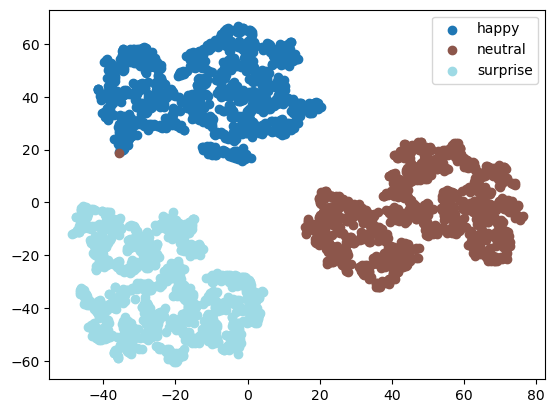

In [11]:
label_names = train_data.class_names
cmap = colormap.get_cmap('tab20',len(label_names))
colors = [cmap(i) for i in range(len(label_names))]
features = []
labels = []

with torch.no_grad():
    for images, target in train_loader:
        images = images.to(device) 
        outputs = best_model(images)
        features.append(outputs.view(outputs.size(0), -1).cpu().numpy())
        labels.append(target.cpu().numpy())
        
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)
tsne = TSNE(n_components=2, random_state=0)
tsne_features = tsne.fit_transform(features)

for label_id in range(len(label_names)):
    mask = (labels == label_id).flatten()
    plt.scatter(tsne_features[mask, 0], tsne_features[mask, 1], c=colors[label_id], label=label_names[label_id])
plt.legend()
plt.show()


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]

Test Results:
Test Accuracy: 0.8255

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       340
           1       0.78      0.84      0.81       340
           2       0.87      0.83      0.85       340

    accuracy                           0.83      1020
   macro avg       0.83      0.83      0.83      1020
weighted avg       0.83      0.83      0.83      1020



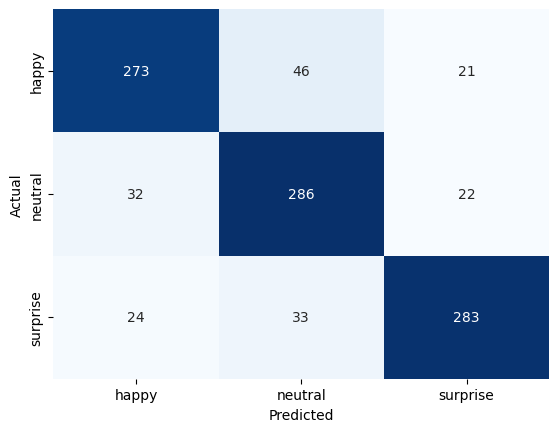

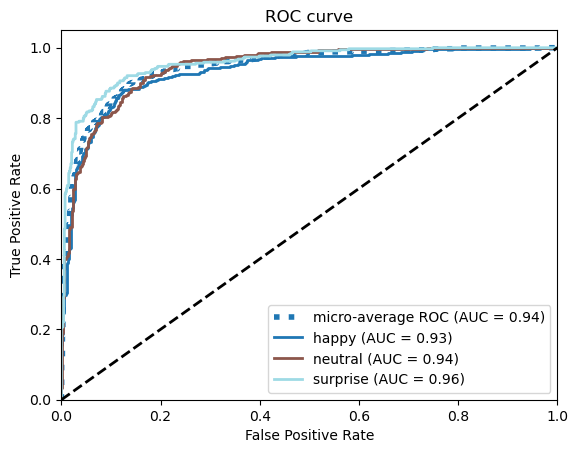

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_hyperparams['lr'])
test_model(best_model, test_loader, criterion, device)